Measurement for the known 6328 Angstrum laser is: 6350.357794040495 
Therefore the calibration is: 22.158


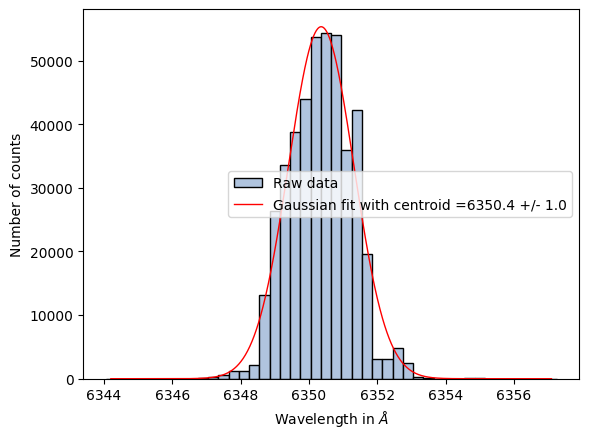

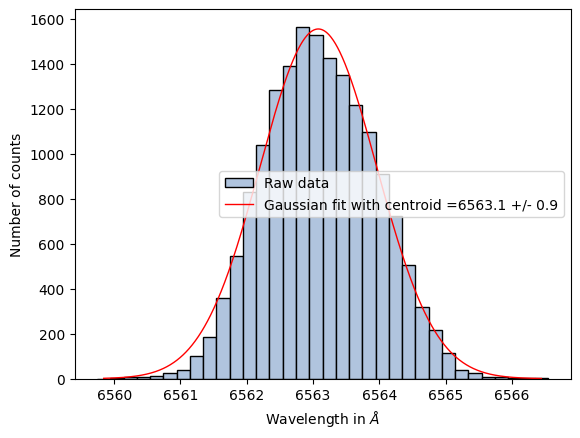

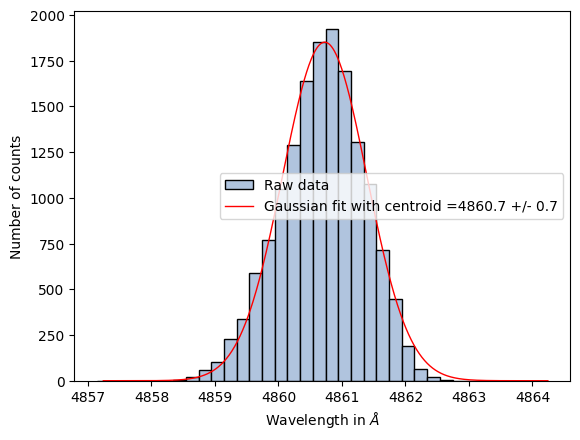

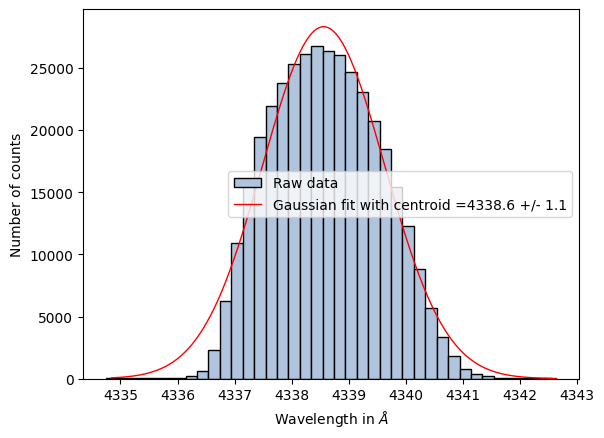

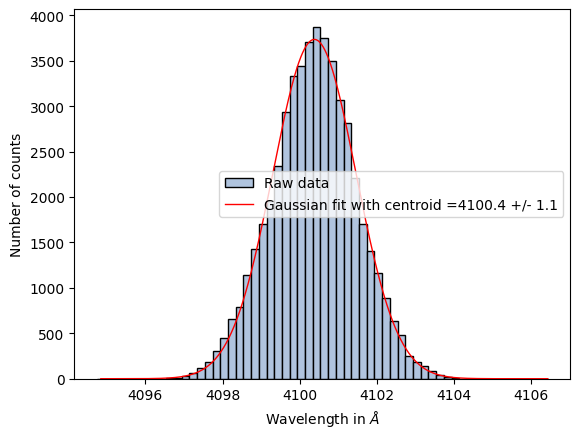

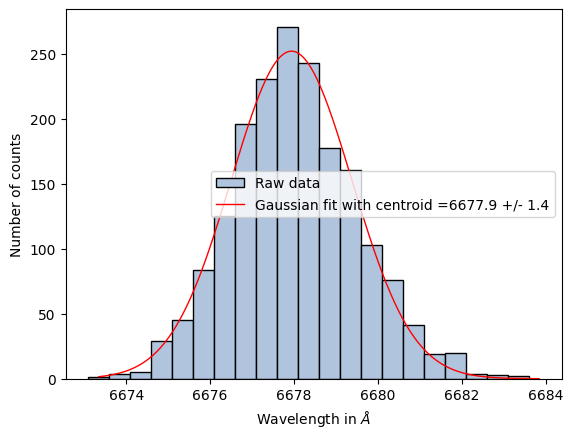

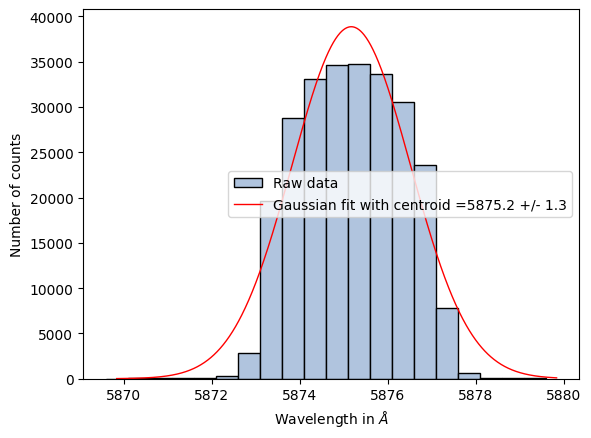

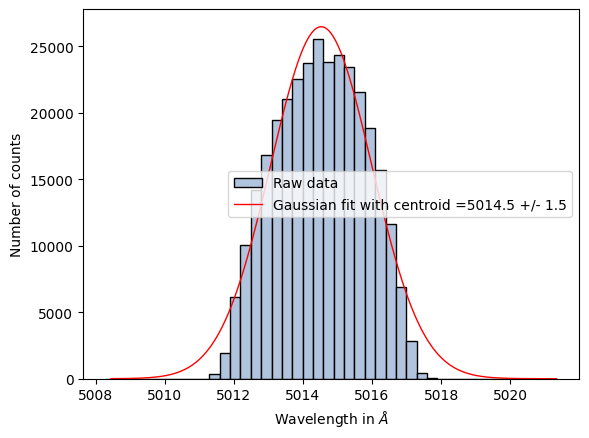

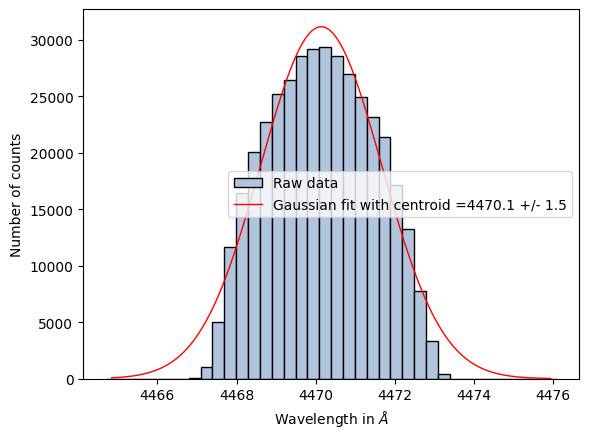

In [33]:
import math
import statistics
import numpy as np 
import scipy as sp
import matplotlib.ticker as ticker
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import UnweightedLinearLeastSquares

wavelength = np.zeros(200)
counts = np.zeros(200)
udata = np.zeros(200)

def gaussian(x, A, mu, sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))
def linear(x,m,c):
    return m*x + c

def rydberg_coefficient(m):
    m = np.array(m)  # Convert list to NumPy array
    return 1/4 - 1/(m ** 2)

def readData(filename):
    f = open(filename,'r')         # open file
    f.readline()                   # read and ignore header
    global i
    i = 0

    for line in f:                          # loop over lines
        line = line.strip()
        columns = line.split(',')
        wavelength[i] = float(columns[0])
        counts[i] = float(columns[1])
        udata[i] = np.sqrt(counts[i])
        i = i + 1
    f.close()

def plotHistogram(title,step):
    fig, ax = plt.subplots()

    #ax.set_title(title)
    ax.set_xlabel("Wavelength in "+r'$\AA$')
    ax.set_ylabel("Number of counts")
    bins = np.arange(np.min(wavelength[0:i]),np.max(wavelength[0:i])+step,step)
    plt.hist(wavelength, bins=bins-step/2, weights=counts, histtype='bar',color='lightsteelblue',ec='black',label='Raw data')

def fitGaussian(calibraiton):    
    A = np.max(counts[0:i])
    sig=np.std(counts[0:i])/(1/0.004)
    mu = wavelength[np.argmax(counts[0:i])]
    p0 = [A, mu, sig]   #List of initial guesses
    popt,pcov = curve_fit(gaussian, wavelength[0:i], counts[0:i],p0, sigma=udata[0:i])
    popt[2] = abs(popt[2])
    modelWavelength = np.linspace(wavelength[0],wavelength[i-1],1000)

    yfit=gaussian(modelWavelength, *popt) #Vectorised
    plt.plot(modelWavelength, yfit, '-r', label = 'Gaussian fit with centroid ='+str(np.round(popt[1],1))+' +/- '+str(np.round(popt[2],1)), linewidth = 1)
    plt.legend()
    return popt[1],popt[2]

#Calibration
filename = "data/calibration.csv"
msg="Calibration For HeNe Laser Emission Line"

readData(filename)
plotHistogram(msg,step=0.3)
mean,stDev = fitGaussian(0)
calibraiton = np.round(mean-6328.2,3)
print("Measurement for the known 6328 Angstrum laser is:",mean,"\nTherefore the calibration is:",calibraiton)
plt.show()

wavelength = np.zeros(200)
counts = np.zeros(200)
udata = np.zeros(200)

H_centroid = []
frac_u = []
#Hydrogen
for x in range(1,5):
    filename = "data/Hydrogen_" + str(x) + ".csv"
    msg="Calibrated hydrogen balmer emission line "+ str(x)
    
    readData(filename)
    wavelength[0:i] = wavelength[0:i] -calibraiton

    plotHistogram(msg,step=0.2)
    mean,stDev = fitGaussian(calibraiton)
    H_centroid.append(mean)
    frac_u.append((stDev)/mean)
    plt.show()
    
    wavelength = np.zeros(200)
    counts = np.zeros(200)
        
#Helium 
steps=[0.5,0.5,0.3,0.3]   
for x in range(1,5):
    filename = "data/Helium_" + str(x) + ".csv"
    msg="Calibrated helium emission line "+ str(x)
    
    readData(filename)
    wavelength[0:i] = wavelength[0:i] -calibraiton
    
    plotHistogram(msg,steps[x-1])
    mean,stDev = fitGaussian(calibraiton)
    plt.show()
    
    wavelength = np.zeros(200)
    counts = np.zeros(200)

The weighted linear fit

Therefore the Rydberg Constant is the value of the gradient: 1.0981e+07 +/- 5202.8
The difference to the known value of 10 973 731.6 is: 7446.0
Chi square:  0.7606105380537032
Number of degrees of freedom:  2
Chi square per degree of freedom:  0.3803052690268516



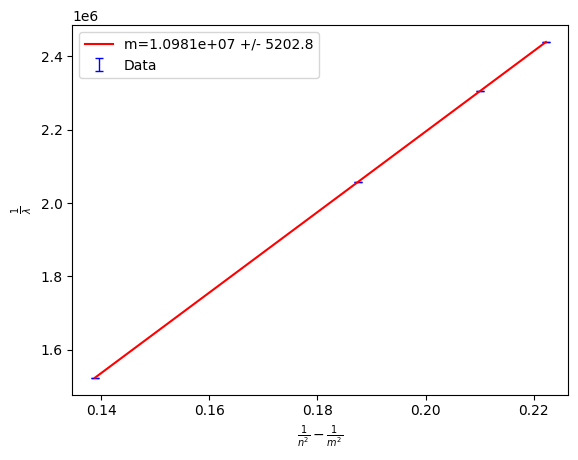

In [34]:
ms = [3,4,5,6]
xdata = rydberg_coefficient(ms)
frac_u = np.array(frac_u)

plt.xlabel(r'$\frac{1}{n^2}-\frac{1}{m^2}$')
plt.ylabel(r'$\frac{1}{\lambda}$')
ydata = 1 / ((np.array(H_centroid))* 1e-10)
uncertainty = ydata*frac_u

#The fit
popt,pcov = curve_fit(linear, xdata, ydata, sigma = uncertainty, absolute_sigma = True)
yfit=linear(xdata, *popt)

#Processing and outputting results
formatted_number = formatted_number = f"{popt[0]:.4e}"
formatted_error = str(np.round(np.sqrt(pcov[0, 0]),1))
print("Therefore the Rydberg Constant is the value of the gradient:",formatted_number,'+/-',formatted_error)
print("The difference to the known value of 10 973 731.6 is:",np.round(popt[0]-10973731.6))

#Quality of fit
dymin = (ydata - linear(xdata,*popt))/uncertainty
min_chisq = sum(dymin*dymin)
dof = len(xdata) - len(popt)

print("Chi square: ", min_chisq)
print("Number of degrees of freedom: ",dof)
print("Chi square per degree of freedom: ",min_chisq/dof)
print()

#Plot
#plt.scatter(xdata,ydata)
plt.errorbar(xdata,ydata,uncertainty, capsize = 3, color = 'blue', linewidth = 1, label = 'Data', ls = 'none')
plt.plot(xdata,yfit,'-r',label='m='+formatted_number+' +/- '+formatted_error)

plt.legend()
plt.show()